In [14]:
import pickle

import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pymbar

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from _BAR_estimator import get_values_from_trace
from _BAR_estimator import bayes_factor_smc
from _BAR_estimator import draw_normal_samples
from _BAR_estimator import pot_ener_normal_aug
from _BAR_estimator import bootstrap_BAR
from _BAR_estimator import fit_uniform_trace
from _BAR_estimator import draw_uniform_samples
from _BAR_estimator import pot_ener_uniform_aug
from _BAR_estimator import pot_ener

In [2]:
SEED = 428
SIZE = 20

SMC_STEPS = 50000
MET_STEPS = 50000

[mu]
[mu]
[mu, sigma_interval__]


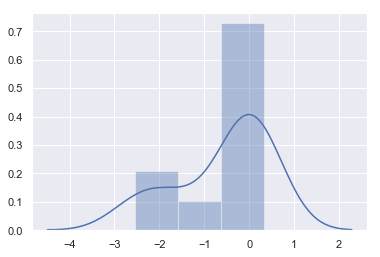

In [3]:
rnd = np.random.RandomState(SEED)
x = rnd.normal(loc=0, scale=1, size=10)
sns.distplot(x)

with pm.Model() as model_1:
    mu = pm.Normal("mu", mu=3, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
print(model_1.vars)

with pm.Model() as model_2:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=x)
print(model_2.vars)

with pm.Model() as model_3:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0.5, upper=2)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=x)
print(model_3.vars)

# Sequential Monte Carlo

Sample initial stage: ...
Stage: 0 Beta: 0.034 Steps: 25
Stage: 1 Beta: 0.090 Steps: 4
Stage: 2 Beta: 0.194 Steps: 3
Stage: 3 Beta: 0.421 Steps: 4
Stage: 4 Beta: 1.000 Steps: 3


Log10 marginal likelihood: -9.19000


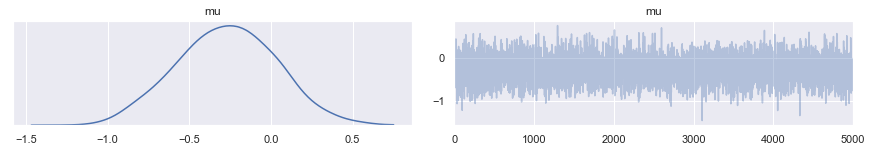

In [4]:
with model_1:
    trace_m1 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m1[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_1.marginal_likelihood)))

Sample initial stage: ...
Stage: 0 Beta: 0.459 Steps: 25
Stage: 1 Beta: 1.000 Steps: 4


Log10 marginal likelihood: -6.70822


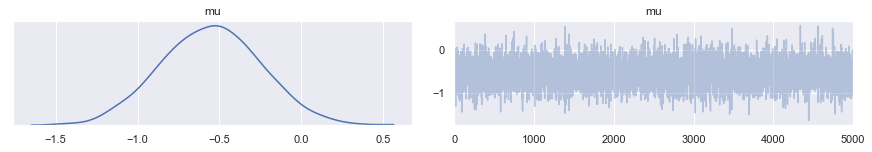

In [5]:
with model_2:
    trace_m2 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m2[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_2.marginal_likelihood)) )

Sample initial stage: ...
Stage: 0 Beta: 0.419 Steps: 25
Stage: 1 Beta: 1.000 Steps: 7


Log10 marginal likelihood: -7.06260


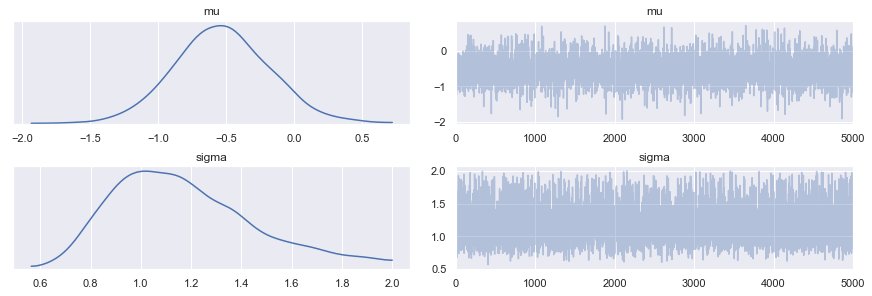

In [6]:
with model_3:
    trace_m3 = pm.sample(SMC_STEPS, step=pm.SMC())
pm.traceplot(trace_m3[::10])

print("Log10 marginal likelihood: %0.5f" %(np.log10(model_3.marginal_likelihood)) )

In [7]:
bf_smc_2_vs_1 = bayes_factor_smc(model_1, model_2)
print("Log10 of Bayes factor model 2 over model 1: %0.5f" % bf_smc_2_vs_1)

bf_smc_3_vs_2 = bayes_factor_smc(model_2, model_3)
print("Log10 of Bayes factor model 3 over model 2: %0.5f" % bf_smc_3_vs_2)

Log10 of Bayes factor model 2 over model 1: 2.48178
Log10 of Bayes factor model 3 over model 2: -0.35438


In [8]:
def bayes_factor_same_nr_vars(model_ini, sample_ini, model_fin, sample_fin, aug_mu_sigma, bootstrap=None):
    varnames = list(sample_ini.keys())
    assert varnames == list(sample_fin.keys()), "sample_ini and sample_fin do not have the same keys"
    
    nsamples_ini = len(sample_ini[varnames[0]])
    nsamples_fin = len(sample_fin[varnames[0]])
    
    sample_aug_ini = draw_normal_samples(aug_mu_sigma, nsamples_ini)
    sample_aug_fin = draw_normal_samples(aug_mu_sigma, nsamples_fin)
    
    # potential for sample drawn from i estimated at state i
    u_i_i = pot_ener_normal_aug(sample_ini, model_ini, sample_aug_ini, aug_mu_sigma)
    
    # potential for sample drawn from i estimated at state f
    u_i_f = pot_ener_normal_aug(sample_ini, model_fin, sample_aug_ini, aug_mu_sigma)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener_normal_aug(sample_fin, model_fin, sample_aug_fin, aug_mu_sigma)
    
    # potential for sample drawn from f estimated at state i
    u_f_i = pot_ener_normal_aug(sample_fin, model_ini, sample_aug_fin, aug_mu_sigma)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

In [9]:
def bayes_factor_diff_nr_vars(model_ini, sample_ini, model_fin, sample_fin, bootstrap=None):
    
    lower_upper_fin = fit_uniform_trace(sample_fin)
    lower_upper_fin = {"sigma_interval__": lower_upper_fin["sigma_interval__"]}
    nsamples_ini = len(sample_ini["mu"])
    sample_aug_ini = draw_uniform_samples(lower_upper_fin, nsamples_ini)
    
    # potential for sample drawn from i estimated at state i
    u_i_i = pot_ener_uniform_aug(sample_ini, model_ini, sample_aug_ini, lower_upper_fin)
    
    # potential for sample drawn from i estimated at state f
    sample_ini_comb = sample_ini.copy()
    sample_ini_comb.update(sample_aug_ini)
    u_i_f = pot_ener(sample_ini_comb, model_fin)
    
    # potential for sample drawn from f estimated at state f
    u_f_f = pot_ener(sample_fin, model_fin)
    
    # potential for sample drawn from f estimated at state i
    sample_fin_split = {"mu": sample_fin["mu"]}
    sample_aug_fin = {"sigma_interval__": sample_fin["sigma_interval__"]}
    u_f_i = pot_ener_uniform_aug(sample_fin_split, model_ini, sample_aug_fin, lower_upper_fin)
    
    w_F = u_i_f - u_i_i
    w_R = u_f_i - u_f_f

    delta_F = pymbar.BAR(w_F, w_R, compute_uncertainty=False, relative_tolerance=1e-12, verbose=True)
    bf = -delta_F

    if bootstrap is None:
        print("log10(bf) = %0.5f" % (bf *np.log10(np.e)))
        return bf
    else:
        print("Running %d bootstraps to estimate error." % bootstrap)
        bf_err = bootstrap_BAR(w_F, w_R, bootstrap)
        print("log10(bf) = %0.5f +/- %0.5f" % (bf * np.log10(np.e), bf_err * np.log10(np.e)))
        return bf, bf_err

# Metropolis MC

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:20<00:00, 5036.93draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c207f0780>,
      dtype=object)

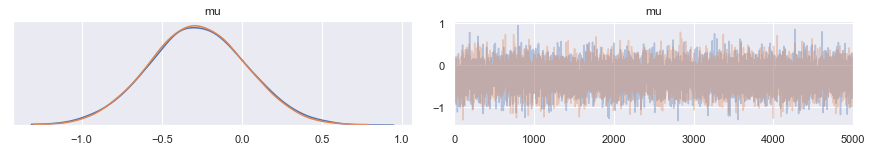

In [10]:
with model_1:
    trace_m1 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m1[::10])

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:27<00:00, 3735.69draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c21653358>,
      dtype=object)

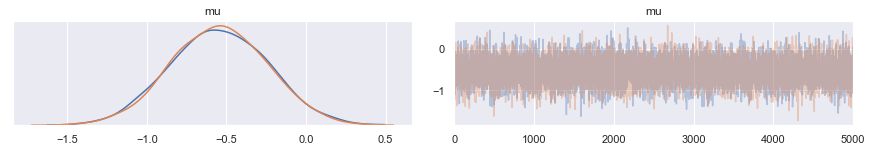

In [11]:
with model_2:
    trace_m2 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m2[::10])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:25<00:00, 3902.36draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20c6ee10>,
      dtype=object)

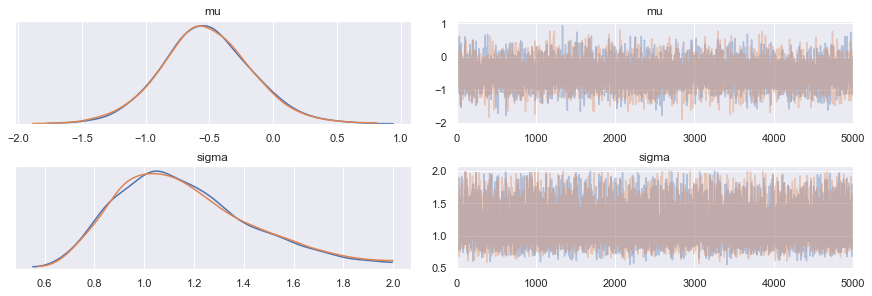

In [12]:
with model_3:
    trace_m3 = pm.sample(MET_STEPS, step=pm.Metropolis())
pm.traceplot(trace_m3[::10])

In [15]:
sample_m1 = get_values_from_trace(model_1, trace_m1)
sample_m2 = get_values_from_trace(model_2, trace_m2)
sample_m3 = get_values_from_trace(model_3, trace_m3)

## BAR estimate without augmenting

In [16]:
bayes_factor_same_nr_vars(model_1, sample_m1, model_2, sample_m2, {}, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =           -5.737
relative_change =        0.000
iteration     1: DeltaF =           -5.737
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 2 iterations (5 function evaluations)
DeltaF =   -5.737
Running 100 bootstraps to estimate error.
log10(bf) = 2.49146 +/- 0.00085


(5.7368044368885345, 0.001951940060784812)

## BAR estimate with augmenting

In [17]:
aug_mu_sigma = {}
aug_mu_sigma["x1"] = {"mu": 0, "sigma":1}
aug_mu_sigma["x2"] = {"mu": 0, "sigma":2}
aug_mu_sigma["x3"] = {"mu": 1, "sigma":1}
aug_mu_sigma["x4"] = {"mu": 1, "sigma":2}

bayes_factor_same_nr_vars(model_1, sample_m1, model_2, sample_m2, aug_mu_sigma, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =           -5.737
relative_change =        0.000
iteration     1: DeltaF =           -5.737
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 2 iterations (5 function evaluations)
DeltaF =   -5.737
Running 100 bootstraps to estimate error.
log10(bf) = 2.49146 +/- 0.00082


(5.7368044368885345, 0.0018851294643194687)

## BAR estimate with two models having different number of variables

In [18]:
bayes_factor_diff_nr_vars(model_2, sample_m2, model_3, sample_m3, bootstrap=100)

relative_change =        1.000
iteration     0: DeltaF =            0.816
relative_change =        0.000
iteration     1: DeltaF =            0.816
Convergence achieved.
Converged to tolerance of 1.000000e-15 in 2 iterations (5 function evaluations)
DeltaF =    0.816
Running 100 bootstraps to estimate error.
log10(bf) = -0.35442 +/- 0.00181


(-0.81608684240042, 0.004171525359380561)